In [0]:
# Import modules
from google.colab import files
import matplotlib.pyplot as plt
from functools import *
import seaborn as sns
import pandas as pd
import numpy as np
np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


# **Import and Setup**

In [0]:
uploaded = files.upload()
file_name = "heart.csv"

Saving heart.csv to heart.csv


In [0]:
dataset = pd.read_csv(file_name, delimiter=',')
print(dataset.shape)
dataset.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
# Shuffle the dataset
# NOTE: shuffle dataframe in-place and reset the index
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values

In [0]:
# Model Evaluation
def model_evaluation_classification(xvalid, yvalid, model):
    prediction = model.predict(xvalid)
    accuracy = accuracy_score(yvalid, prediction.round()) * 100.0
    precision = precision_score(yvalid, prediction.round(), average='micro') * 100.0
    recall = recall_score(yvalid, prediction.round(), average='micro') * 100.0
    f1score = f1_score(yvalid, prediction.round(), average='micro')

    print("Accuracy: %.2f%%" % (accuracy))
    print("Precision: %.2f%%" % (precision))
    print("Recall: %.2f%%" % (recall))
    print("F1-score: %.2f\n" % (f1score))

def model_evaluation_regression(xvalid, yvalid, model):
    prediction = model.predict(xvalid)
    mae = mean_absolute_error(yvalid, prediction)
    print("MAE: %.2f" % (mae))

# **Binary Classification using XGBClassifier()**

Task #1


In [0]:
X = dataset.drop('sex', axis='columns').values
Y = dataset['sex'].values

In [0]:
xtr, xva, ytr, yva = train_test_split(X, Y, test_size = 0.2, random_state = 123)

In [0]:
# Following are some important parameters: n_estimators=100, max_depth=3
xg_cla = xgb.XGBClassifier(n_estimators=30, max_depth=3)
xg_cla.fit(xtr, ytr, eval_set=[(xva, yva)], verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Evaluate on the training set itself

In [0]:
preds = xg_cla.predict(xtr)

In [0]:
print(ytr[:10])
print(preds[:10])

[0 1 1 0 0 1 1 0 1 0]
[0 1 1 1 1 1 1 0 1 1]


### Evaluate on the validation set

In [0]:
preds = xg_cla.predict(xva)

In [0]:
print(yva[:10])
print(preds[:10])

[1 0 1 1 1 1 1 1 1 1]
[1 0 1 1 0 1 0 0 1 1]


### Evaluation based on precision, accuracy, and recall

In [0]:
model_evaluation_classification(xva, yva, xg_cla)

Accuracy: 68.85%
Precision: 68.85%
Recall: 68.85%
F1-score: 0.69



### Visualize one of the trees

In [0]:
plt.rcParams['figure.figsize'] = [50, 10]

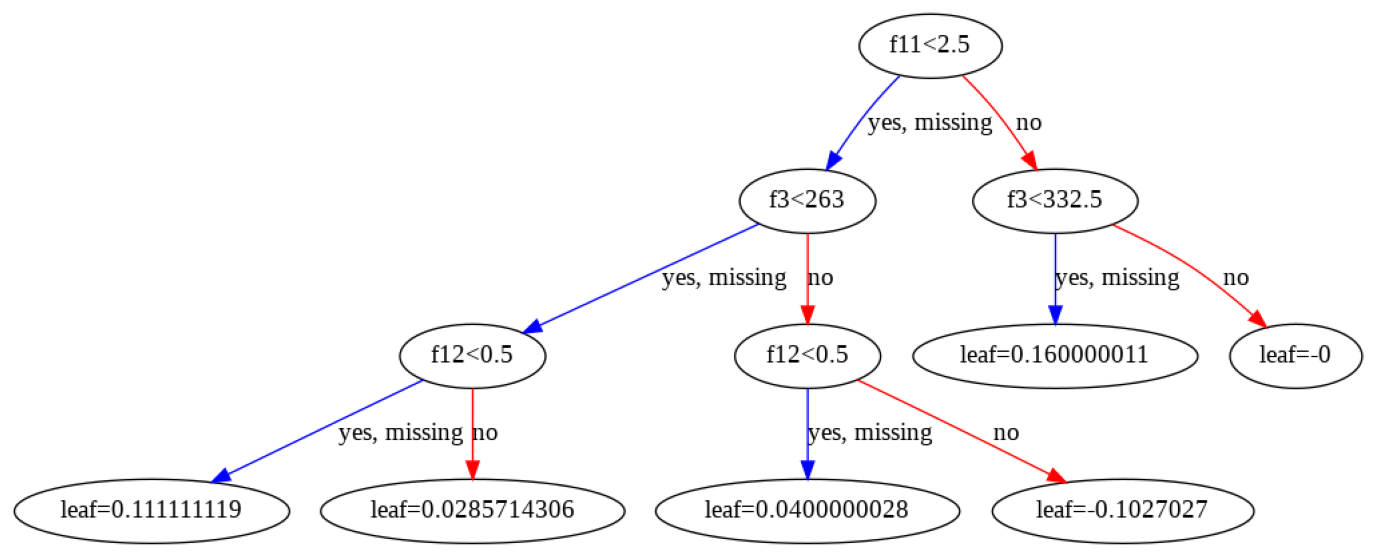

In [0]:
xgb.plot_tree(xg_cla, num_trees=0)

### Visualize a tree with appropriate feature names

In [0]:
f = open(file_name)
line = f.readline()
f.close()
cols = line.strip().split(',')
print(cols)

del cols[1] # Remove the output column (sex)
f = open('fmap1.txt', 'w')
for i, col in enumerate(cols):
    f.write(str(i) + '\t' + str(col) + '\tq\n')
f.close()

! cat fmap1.txt

['\ufeffage', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
0	﻿age	q
1	cp	q
2	trestbps	q
3	chol	q
4	fbs	q
5	restecg	q
6	thalach	q
7	exang	q
8	oldpeak	q
9	slope	q
10	ca	q
11	thal	q
12	target	q


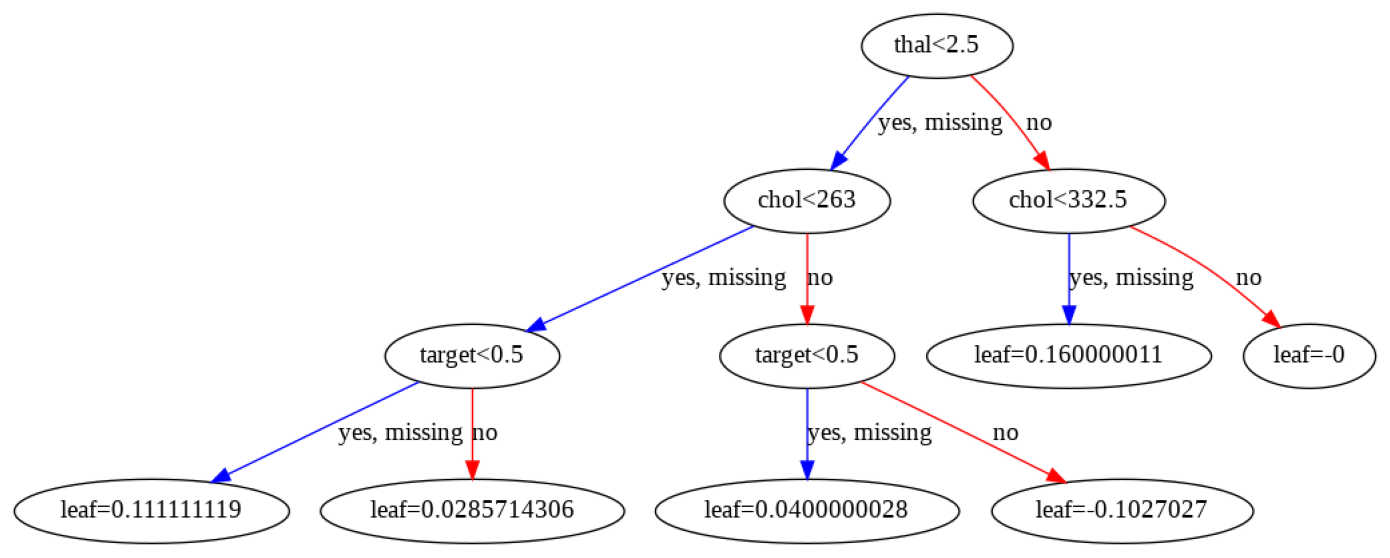

In [0]:
xgb.plot_tree(xg_cla, num_trees=0, fmap='fmap1.txt')

**Comment:** if thalach is more than 2.5 and less than 176, and age is less than 38, then the gender is less likely a male.

# **Regression using XGBRegressor()**

Task #1


In [0]:
X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values

In [0]:
xtr, xva, ytr, yva = train_test_split(X, Y, test_size = 0.2, random_state = 456)

In [0]:
# Following are some important parameters: n_estimators=100, max_depth=3
xg_reg = xgb.XGBRegressor(n_estimators=30, max_depth=3, objective='reg:squarederror')
xg_reg.fit(xtr, ytr, eval_set=[(xva, yva)], verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=30,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### Evaluate on the training set itself

In [0]:
preds = xg_reg.predict(xtr)

In [0]:
print(ytr[:10])
print(preds[:10])

[61 61 62 55 54 54 54 70 62 43]
[ 55.6  56.5  56.7  57.1  53.9  56.1  52.7  58.6  57.0  43.3]


### Evaluate on the validation set

In [0]:
preds = xg_reg.predict(xva)

In [0]:
print(yva[:10])
print(preds[:10])

[58 41 43 41 63 70 64 55 67 41]
[ 48.6  42.0  53.2  47.3  56.3  57.4  57.0  53.3  57.4  48.7]


### Evaluation based on MAE

In [0]:
model_evaluation_regression(xva, yva, xg_reg)

MAE: 6.15


### Visualize one of the trees

In [0]:
plt.rcParams['figure.figsize'] = [50, 10]

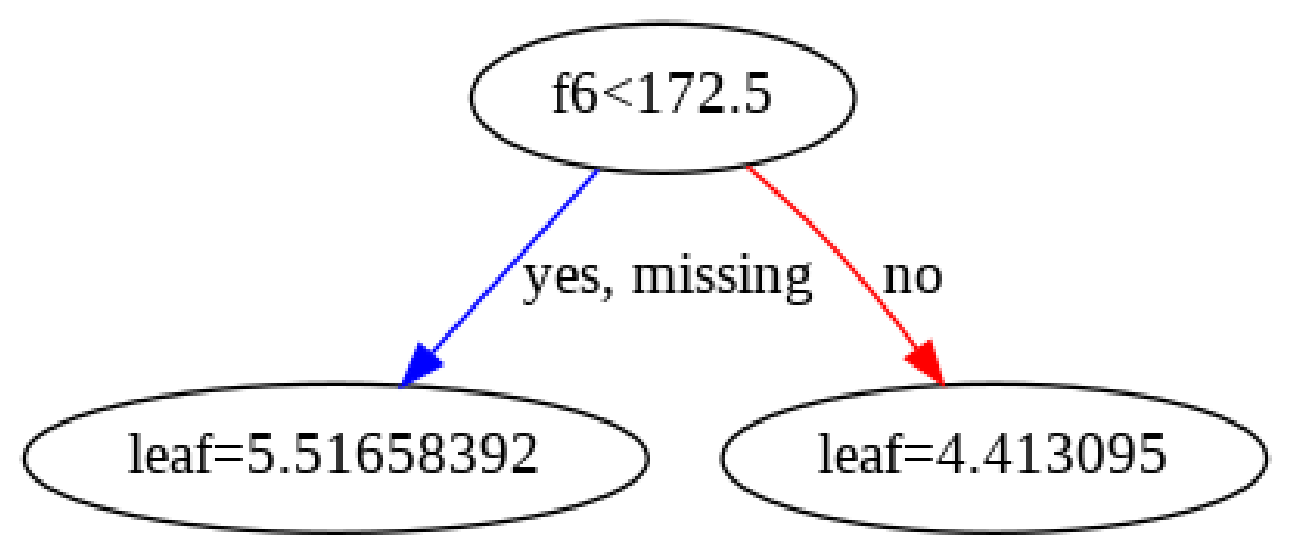

In [0]:
xgb.plot_tree(xg_reg, num_trees=0)

### Visualize a tree with appropriate feature names

In [0]:
f = open(file_name)
line = f.readline()
f.close()
cols = line.strip().split(',')
print(cols)

del cols[0] # Remove the output column (age)
f = open('fmap2.txt', 'w')
for i, col in enumerate(cols):
    f.write(str(i) + '\t' + str(col) + '\tq\n')
f.close()

! cat fmap2.txt

['\ufeffage', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
0	sex	q
1	cp	q
2	trestbps	q
3	chol	q
4	fbs	q
5	restecg	q
6	thalach	q
7	exang	q
8	oldpeak	q
9	slope	q
10	ca	q
11	thal	q
12	target	q


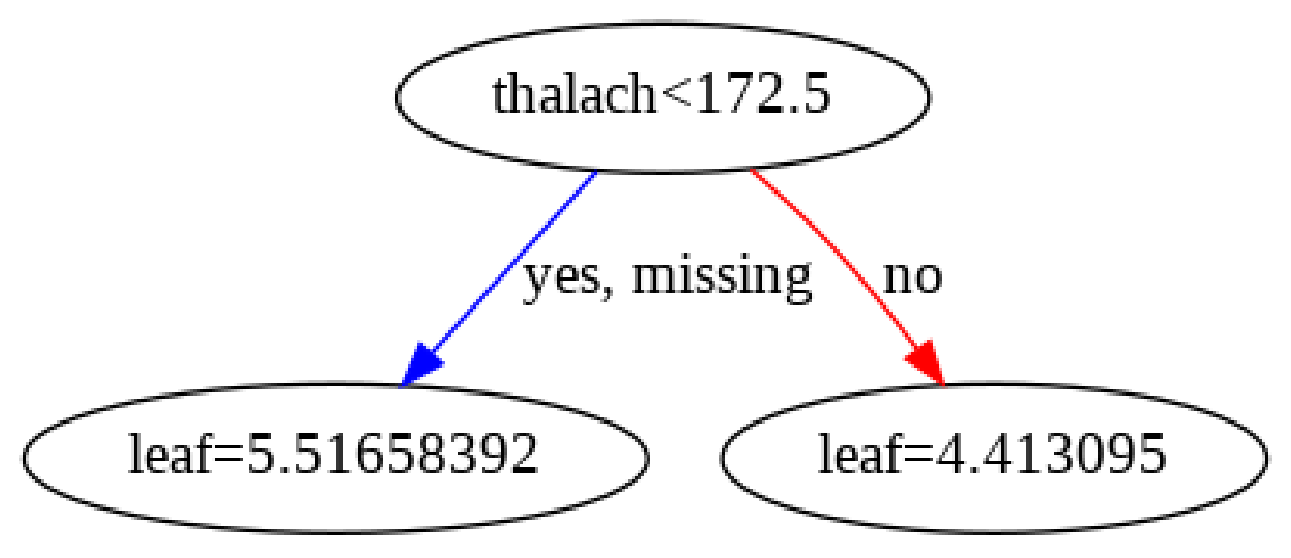

In [0]:
xgb.plot_tree(xg_reg, num_trees=0, fmap='fmap2.txt')

# **NN Model (Binary Classification)**

In [0]:
X = dataset.drop('sex', axis='columns').values
Y = dataset['sex'].values
xtr, xva, ytr, yva = train_test_split(X, Y, test_size = 0.2, random_state = 789)

In [0]:
callback_a = ModelCheckpoint(filepath = "classification.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

model_classification = Sequential()
model_classification.add(Dense(13, input_dim=len(xtr[0, :]), activation='relu'))
model_classification.add(Dense(7, activation='relu'))
model_classification.add(Dense(1, activation='sigmoid'))

model_classification.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history_classification = model_classification.fit(xtr, ytr, validation_data=(xva, yva), epochs=1024, batch_size=100, callbacks = [callback_a, callback_b], verbose=0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Evaluation based on precision, accuracy, and recall

In [0]:
model_evaluation_classification(xva, yva, model_classification)

Accuracy: 67.21%
Precision: 67.21%
Recall: 67.21%
F1-score: 0.67



**Comment:** Interesting! XGB is better than NN model!

# **NN Model (Regression)**

In [0]:
X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values
xtr, xva, ytr, yva = train_test_split(X, Y, test_size = 0.2, random_state = 777)

In [0]:
callback_a = ModelCheckpoint(filepath = "regression.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

model_regression = Sequential()
model_regression.add(Dense(13, input_dim=len(xtr[0, :]), activation='relu'))
model_regression.add(Dense(7, activation='relu'))
model_regression.add(Dense(1, activation='linear'))

model_regression.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
history_regression = model_regression.fit(xtr, ytr, validation_data=(xva, yva), epochs=1024, batch_size=100, callbacks = [callback_a, callback_b], verbose=0)

In [0]:
model_evaluation_regression(xva, yva, model_regression)

MAE: 8.23


**Comment:** XGB is better than NN regression model